# First look at the data

Features dimension (70000, 784) Target dimension (70000,)
Some digit = 5.0


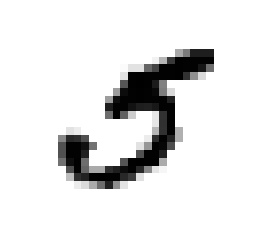

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

X, y = mnist["data"], mnist["target"]
print("Features dimension", X.shape, "Target dimension", y.shape)

print("Some digit =", y[36000])
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

# Train a binary classifier detecting digit = 5

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_predict

shuffle_index = np.random.permutation(60000)
X_train, X_test, y_train, y_test = X[:60000][shuffle_index], X[60000:], y[:60000][shuffle_index], y[60000:]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

# Check precision

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
# In cross val predict each instance enters the test set once 
# there is no taking the average of anything as in cross val score)
print("Confusion matrix", confusion_matrix(y_train_5, y_train_pred))

 Precision = $\frac{TP}{TP+FP}$
 Recall = $\frac{TP}{TP+FN}$
 F1 score is harmonic mean of Precision and recall where Harmonic means is $\frac{n}{\sum_1^n\frac{1}{x_i}}$

In [32]:
print("Precision score", precision_score(y_train_5, y_train_pred))
print("Recall score", recall_score(y_train_5, y_train_pred))
#f_1 score is the harmonic mean of precision and recall 
print ("f_1 score", f1_score(y_train_5, y_train_pred))

# Ref.
# sklearn.metrics.precision_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)[source]
# sklearn.metrics.recall_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)[source]¶

Precision score 0.84934086629
Recall score 0.665559859804
f_1 score 0.74630261661


# Check decision scores

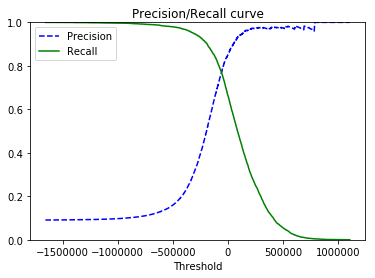

In [63]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, title = "Precision/Recall curve"):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "upper left")
    plt.ylim([0, 1])
    plt.title(title)
    
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


In [45]:
#select threshold to reach precision = 90%
y_train_pred_90 = (y_scores > 70000)
print("Precision score", precision_score(y_train_5, y_train_pred_90))
print("Recall score", recall_score(y_train_5, y_train_pred_90))

Precision score 0.915955766193
Recall score 0.534772182254


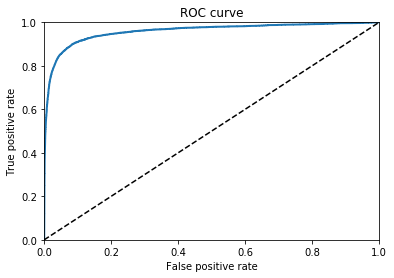

AUC 0.958780973817


In [62]:
#Roc curve is a plot of true positive rate (TPR = recall) against FPR ( = 1 - true negative rate)
from sklearn.metrics import roc_curve, roc_auc_score
def plot_roc_curve(fpr, tpr, label = None, title = "ROC curve"):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()

print("AUC", roc_auc_score(y_train_5, y_scores))

# SGDClassifier versus random forest

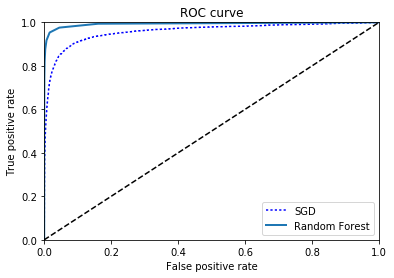

AUC score forest 0.992954266871


In [67]:
from sklearn.ensemble import RandomForestClassifier 
forest_clf = RandomForestClassifier(random_state = 42)
# predict proba returns 1 row per instance, and a col per class [not a 5, a 5]
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

print("AUC score forest", roc_auc_score(y_train_5, y_scores_forest))

# Multiclass classification

In [77]:
from sklearn.multiclass import OneVsOneClassifier

sgd_clf.fit(X_train, y_train)
some_digit_scores = sgd_clf.decision_function([some_digit])
print("Class found using default OVA strategy", np.argmax(some_digit_scores))

# Force one vs one
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
print("Class found using forced OVO", ovo_clf.predict([some_digit]))

forest_clf.fit(X_train, y_train)
print("Class probab using forest", forest_clf.predict_proba([some_digit]))

Class found using default OVA strategy 5
Class found using forced OVO [ 5.]
Class probab using forest [[ 0.   0.   0.   0.1  0.   0.9  0.   0.   0.   0. ]]


In [78]:
#Check accuracy
print("CV accuracy", cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy"))
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv = 3)

array([ 0.83888222,  0.86499325,  0.87098065])

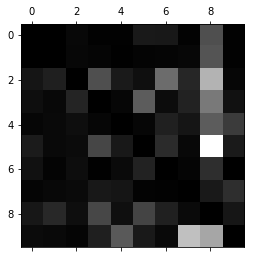

In [81]:
#Check confusion rate mtx (col = predicted class, row = actual class)
conf_mx = confusion_matrix(y_train, y_train_pred)
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

# Exercise

In [ ]:
# Ex 1
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

mnist = fetch_mldata('MNIST original')
X, y = mnist["data"], mnist["target"]
shuffle_index = np.random.permutation(60000)
X_train, X_test, y_train, y_test = X[:60000][shuffle_index], X[60000:], y[:60000][shuffle_index], y[60000:]
param_grid = [
    {'weights': ['uniform', 'distance'],
     'n_neighbors': [5, 10] 
    }
]

knnClassifier = KNeighborsClassifier()
grid_search = GridSearchCV(knnClassifier, param_grid, cv = 2, scoring = 'neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best estimator: ", grid_search.best_estimator_)
print("*** Individual scores ***")
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)